# The Pong Game - Reinforcement Learning Problem

## Problem Statement

Reinforcement learning (RL) is going to be used to adapt the system to self train. RL is a form of semi-supervised learning where an Agent (Algorithm) receives feedback from the Environment (Game), and based on the feedback makes critical decisions to maximum Reward (Scores).

Here is some of the theory applied to design the solution:
1. State ($s$)- Current situation returned by the environment, this has the current ball and rectangle position
2. Reward ($r$) - the immediate return sent back  from the environment to evaluate the last action, reward is one when the rectangle hits the ball
3. Policy} ($\pi$) - the strategy that the agent employs to determine the next action based on the current state, the policy is to maximize the chances of the ball hitting the rectangle
3. Action ($a$) - All the possible decisions the model can take, make the rectangle either move right or left

Markov decision process formally describe an environment for reinforcement learning where the environment is fully observable. Reinforcement Learning Process are formulated through the Markov Decision Process. Markov property states that the future is independent of the past given the present.

\begin{equation}
   \mathbb{P}[S_{t+1}] = \mathbb{P}[S_{t+1 }  |  S_{1}..., S_{t}]
\end{equation}

The state at a time $t+1$ captures all the relevant information from history. Once the state is known, the history can be thrown away - the state is a sufficient statistic for the future. In predicting the price of the future stocks, the previous prices are really irrelevant. Such is an example of the Markov Process because it has Markov property.

What does this mean to us? It means at any particular moment, by knowing the state of the rectangle and ball we can make a decision to move the ball right or left.

## The Code

In [9]:
#import the necessary libraries
from env import Pong
import numpy as np
import pygame, sys
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#Keras library for the neural network
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense

#to scale data in the range of 0 and 1
from sklearn.preprocessing import StandardScaler

The pong game is a Reinforcement learning problem. 

Play the pong game for 1000 steps and get the initial data, at each step the action is randomly selected. 1 is for moving left and 0 is for moving right. The reward is 1 for preventing the ball hitting the bottom surface and 0 when the ball goes past the bottom surface.

## The game dynamics

The game-playing agent controls the red bar at the bottom of the screen. The ball moves at a constant speed, and bounces off the edges of the game area (or the red bar) at a constant angle. During the training phase, the rectangle moves randomly at the bottom, and by chance it may hit the ball. The goal of the research is to learn from these experiences when the all hit the rectangle, and repeat them in similar setup. At each point, we can collect 6 values about the game
1. action - random action initiated by the system  - whether move right 0, or left 1
2. ball_x - the x value of the ball coordinates
3. ball_y - the y value of the ball coordinates
4. rect_x - the x value of the rectangle coordinates
5. rect_y - the y value of the rectangle coordinates
6. reward - whenever the rectangle hits the ball, the reward is one, otherwise it is 0
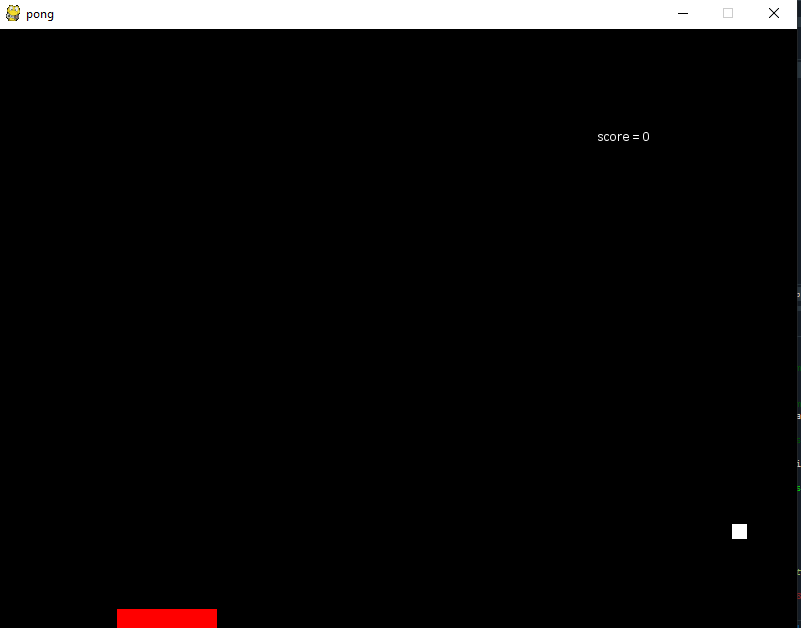

NOTE: An alternative solution is to take the piixel image as state at each stage, and use the pixel image. This is likely to produce better results - the solution on using coordinates is a naive approach that would allow us to bootstrapteh solution quickly.

### Data Exploring

In [2]:
env = Pong()

In [3]:
def get_data(episode_count):
    
    #run the game several times and collect teh data
    for e in range(episode_count):
        numpy_data = env.step(10000) 
        
        #convert numpy to pandas
        data = pd.DataFrame(numpy_data, columns=['action', 'ball_x', 'ball_y', 'rect_x', 'rect_y', 'reward'])
        #establish the direction of the ball and the rectancle at each data point
        data['ball_direx'] = data['ball_x'].diff()
        data['ball_direy'] = data['ball_y'].diff()
        data['rect_direx'] = data['rect_x'].diff()
        #Remove incomplete rows
        data = data.dropna(how = 'any')
        return data

In [4]:
# the game will pop up in another window, please give it some time to finish
data = get_data(20)
pygame.quit()  

In [5]:
#checking the data collected
data.head()

,action,ball_x,ball_y,rect_x,rect_y,reward,ball_direx,ball_direy,rect_direx
1,0.0,60.0,60.0,390.0,580.0,0.0,5.0,5.0,-5.0
2,1.0,65.0,65.0,385.0,580.0,0.0,5.0,5.0,-5.0
3,0.0,70.0,70.0,380.0,580.0,0.0,5.0,5.0,-5.0
4,0.0,75.0,75.0,375.0,580.0,0.0,5.0,5.0,-5.0
5,1.0,80.0,80.0,370.0,580.0,0.0,5.0,5.0,-5.0


In [6]:
#checking out when the rectangle hit the ball
mask = (data['reward'] == 1)
positive_data = data.loc[mask]
positive_data

,action,ball_x,ball_y,rect_x,rect_y,reward,ball_direx,ball_direy,rect_direx
2532,0.0,75.0,565.0,0.0,580.0,1.0,5.0,5.0,0.0
3261,0.0,560.0,565.0,475.0,580.0,1.0,5.0,-5.0,-5.0
3763,1.0,85.0,565.0,0.0,580.0,1.0,-5.0,-5.0,0.0
3779,1.0,5.0,565.0,0.0,580.0,1.0,-5.0,-5.0,0.0
3795,1.0,70.0,565.0,0.0,580.0,1.0,5.0,-5.0,0.0
3811,0.0,150.0,565.0,60.0,580.0,1.0,5.0,-5.0,5.0
3827,0.0,230.0,565.0,140.0,580.0,1.0,5.0,-5.0,5.0
3843,0.0,310.0,565.0,220.0,580.0,1.0,5.0,-5.0,5.0
3859,0.0,390.0,565.0,300.0,580.0,1.0,5.0,-5.0,5.0
3875,1.0,470.0,565.0,380.0,580.0,1.0,5.0,-5.0,5.0


In our case the ball hit the rectable len(positive_data) times

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 1 to 9999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   action      9999 non-null   float64
 1   ball_x      9999 non-null   float64
 2   ball_y      9999 non-null   float64
 3   rect_x      9999 non-null   float64
 4   rect_y      9999 non-null   float64
 5   reward      9999 non-null   float64
 6   ball_direx  9999 non-null   float64
 7   ball_direy  9999 non-null   float64
 8   rect_direx  9999 non-null   float64
dtypes: float64(9)
memory usage: 781.2 KB


## Feature Selection

In our experiment, we need to be able to predict the right action on the rectangle given aset of conditions: the direction of the ball as well as the position relative to the rectangle. We employ the heatmap to find the correlation between the target - action and the features.

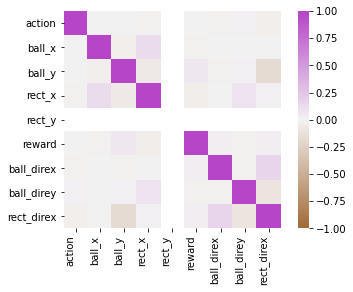

In [10]:
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(40, 300, n=200),
    square=True,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

Expected corr should be as close as possible to 1, against our target action, but most of it is in the rane 0-0.25, so most likely our model won't perform as good. Nevertheless we will continue to illustrate the concepts.

## Replay

Once we have captured enough experiences, we replay them to learn from them. At this point we train the FFNN algorithm. The keras library in python is used to model the algorithm.

In [16]:
def _model():

    #The Feed-Forward Neural Network is used
    #in training the Keras model for the binary classification if the rectangle 
    #should move right or left
    #add layers to model
    model = Sequential()
    model.add(Dense(250, activation='relu', input_shape=(7,)))
    model.add(Dense(250, activation='relu'))
    model.add(Dense(250, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    #compile model using accuracy to measure model performance
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [17]:
model = _model()

Since most of the data is not really useful, it is just the ball and the rectangle moving in their own direction, we shall focus only on points where the ball actually hit the rectangle. We will learn from the experiences of $4$ states before that. $4$ is a random logical number, to say the $4$ last move were responsible for the ball hitting the rectangle.

In [13]:
def expReplay(data, model):

    #The neural network is retrained at this point. Only positive events are considers
    #4 steps before the rectangle hit the ball. Those experiences are the one that are used to build the binary classification
    #so that the algorithm would remember them

    p = 4 #look back parameter
    
    mini_batch = pd.DataFrame(columns=['action', 'ball_x', 'ball_y', 'rect_x', 'rect_y', 'reward',  'ball_direx', 'ball_direy', 'rect_direx'])
    #identify rows when the ball hit the rectangle and 4 events before that and savethem in a mini-batch
    for index, row in data.iterrows():
        if data.at[index, 'reward'] == 1:
            for i in range(p):
                v = index + i - p + 1  #index value to look into the past

                mini_batch = mini_batch.append({'action' : data.at[v , 'action'],
                                                'ball_x' : data.at[v, 'ball_x'],
                                                'ball_y' : data.at[v, 'ball_y'],
                                                'rect_x' : data.at[v, 'rect_x'],
                                                'rect_y' : data.at[v, 'rect_y'],
                                                'reward' : data.at[v, 'reward'],
                                                'ball_direx' : data.at[v, 'ball_direx'],
                                                'ball_direy' : data.at[v, 'ball_direy'],
                                                'rect_direx' : data.at[v, 'rect_direx']},
                                               ignore_index=True)

        #get the features for trainin teh mean batch
        X_train = mini_batch[['ball_x', 'ball_y', 'rect_x', 'rect_y', 'ball_direx', 'ball_direy', 'rect_direx']].to_numpy()

        #get the target for training the mini batch
        y_train = mini_batch['action']

    print('training set size = ' + str(len(X_train)))

    #just making sure there is something in the mini batch
    if len(X_train) > 0:

        #standardization
        scaler  = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)

        #train the model on the mini-batch
        model.fit(X_train, y_train, epochs=300, verbose = 1, validation_split=0.2)

In [14]:
expReplay(data, model)

training set size = 64
Epoch 1/300
2/2 [==============================] - 0s 149ms/step - loss: 0.6858 - accuracy: 0.5882 - val_loss: 0.7784 - val_accuracy: 0.4615
Epoch 2/300
2/2 [==============================] - 0s 27ms/step - loss: 0.6254 - accuracy: 0.6078 - val_loss: 0.8510 - val_accuracy: 0.4615
Epoch 3/300
2/2 [==============================] - 0s 27ms/step - loss: 0.5856 - accuracy: 0.7255 - val_loss: 0.9203 - val_accuracy: 0.4615
Epoch 4/300
2/2 [==============================] - 0s 24ms/step - loss: 0.5685 - accuracy: 0.7647 - val_loss: 1.0066 - val_accuracy: 0.4615
Epoch 5/300
2/2 [==============================] - 0s 26ms/step - loss: 0.5520 - accuracy: 0.7647 - val_loss: 1.0800 - val_accuracy: 0.4615
Epoch 6/300
2/2 [==============================] - 0s 25ms/step - loss: 0.5404 - accuracy: 0.7843 - val_loss: 1.1354 - val_accuracy: 0.4615
Epoch 7/300
2/2 [==============================] - 0s 23ms/step - loss: 0.5268 - accuracy: 0.7843 - val_loss: 1.1900 - val_accuracy: 0.5

Epoch 59/300
2/2 [==============================] - 0s 35ms/step - loss: 0.1212 - accuracy: 0.9804 - val_loss: 2.8100 - val_accuracy: 0.4615
Epoch 60/300
2/2 [==============================] - 0s 83ms/step - loss: 0.1259 - accuracy: 0.9804 - val_loss: 2.8366 - val_accuracy: 0.4615
Epoch 61/300
2/2 [==============================] - 0s 26ms/step - loss: 0.1122 - accuracy: 0.9608 - val_loss: 2.8580 - val_accuracy: 0.4615
Epoch 62/300
2/2 [==============================] - 0s 23ms/step - loss: 0.1139 - accuracy: 0.9608 - val_loss: 2.9428 - val_accuracy: 0.4615
Epoch 63/300
2/2 [==============================] - 0s 24ms/step - loss: 0.1204 - accuracy: 0.9804 - val_loss: 3.0520 - val_accuracy: 0.4615
Epoch 64/300
2/2 [==============================] - 0s 25ms/step - loss: 0.1205 - accuracy: 0.9412 - val_loss: 2.9719 - val_accuracy: 0.4615
Epoch 65/300
2/2 [==============================] - 0s 23ms/step - loss: 0.0992 - accuracy: 1.0000 - val_loss: 2.8900 - val_accuracy: 0.4615
Epoch 66/300


Epoch 117/300
2/2 [==============================] - 0s 23ms/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 4.8070 - val_accuracy: 0.4615
Epoch 118/300
2/2 [==============================] - 0s 27ms/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 4.8307 - val_accuracy: 0.4615
Epoch 119/300
2/2 [==============================] - 0s 29ms/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 4.8513 - val_accuracy: 0.4615
Epoch 120/300
2/2 [==============================] - 0s 26ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 4.8838 - val_accuracy: 0.4615
Epoch 121/300
2/2 [==============================] - 0s 24ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 4.9276 - val_accuracy: 0.4615
Epoch 122/300
2/2 [==============================] - 0s 23ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 4.9722 - val_accuracy: 0.4615
Epoch 123/300
2/2 [==============================] - 0s 30ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 5.0075 - val_accuracy: 0.4615
Epoch 

Epoch 175/300
2/2 [==============================] - 0s 36ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 6.1179 - val_accuracy: 0.3846
Epoch 176/300
2/2 [==============================] - 0s 34ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 6.1284 - val_accuracy: 0.3846
Epoch 177/300
2/2 [==============================] - 0s 36ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 6.1384 - val_accuracy: 0.3846
Epoch 178/300
2/2 [==============================] - 0s 27ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 6.1527 - val_accuracy: 0.3846
Epoch 179/300
2/2 [==============================] - 0s 23ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 6.1724 - val_accuracy: 0.3846
Epoch 180/300
2/2 [==============================] - 0s 24ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 6.1912 - val_accuracy: 0.3846
Epoch 181/300
2/2 [==============================] - 0s 26ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 6.2075 - val_accuracy: 0.3846
Epoch 

Epoch 233/300
2/2 [==============================] - 0s 26ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 6.8507 - val_accuracy: 0.3846
Epoch 234/300
2/2 [==============================] - 0s 26ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 6.8612 - val_accuracy: 0.3846
Epoch 235/300
2/2 [==============================] - 0s 24ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 6.8717 - val_accuracy: 0.4615
Epoch 236/300
2/2 [==============================] - 0s 22ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 6.8804 - val_accuracy: 0.4615
Epoch 237/300
2/2 [==============================] - 0s 29ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 6.8892 - val_accuracy: 0.4615
Epoch 238/300
2/2 [==============================] - 0s 41ms/step - loss: 9.8911e-04 - accuracy: 1.0000 - val_loss: 6.9000 - val_accuracy: 0.4615
Epoch 239/300
2/2 [==============================] - 0s 40ms/step - loss: 9.7641e-04 - accuracy: 1.0000 - val_loss: 6.9131 - val_accuracy: 0.461

2/2 [==============================] - 0s 27ms/step - loss: 5.6061e-04 - accuracy: 1.0000 - val_loss: 7.3993 - val_accuracy: 0.4615
Epoch 290/300
2/2 [==============================] - 0s 28ms/step - loss: 5.5838e-04 - accuracy: 1.0000 - val_loss: 7.4069 - val_accuracy: 0.4615
Epoch 291/300
2/2 [==============================] - 0s 38ms/step - loss: 5.5384e-04 - accuracy: 1.0000 - val_loss: 7.4152 - val_accuracy: 0.4615
Epoch 292/300
2/2 [==============================] - 0s 40ms/step - loss: 5.4724e-04 - accuracy: 1.0000 - val_loss: 7.4237 - val_accuracy: 0.4615
Epoch 293/300
2/2 [==============================] - 0s 26ms/step - loss: 5.4224e-04 - accuracy: 1.0000 - val_loss: 7.4320 - val_accuracy: 0.4615
Epoch 294/300
2/2 [==============================] - 0s 24ms/step - loss: 5.3615e-04 - accuracy: 1.0000 - val_loss: 7.4394 - val_accuracy: 0.4615
Epoch 295/300
2/2 [==============================] - 0s 26ms/step - loss: 5.3661e-04 - accuracy: 1.0000 - val_loss: 7.4468 - val_accuracy:

This would be the first attempt at training the algorithm. As it gets more and more data, it will begin to learn. And instead of guessing the action to take, we become more and more dependent on it. This is controlled by the Epsilon, which is 1 - purely exploratory in the beginning, but should end up at close to zero as we use the algorithm more. 

This is just how the first episode and training would go, and the first training run. We can see that the accuracy is pretty high on the training data, but quite bad on evaluation. The rest code can be run in the application itself.

## Opportunities for improvement

1. Capture the pixel as state and use them as vecctore features - these are bound to produce a model most likely to converge than the coordinates used in this experiment
2. Use the other models like Convolutional Network as they do better with pixel data
3. Try other Deep Neural network frameworks like Tensorflow and Pytorch
4. Improve the game dynamics to run more efficiently and without freezing
